<a href="https://colab.research.google.com/github/lokeshbaranwal/Pose-Estimation-of-Satellite/blob/master/SpeedvL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

dataset_root="/content/gdrive/My Drive/speed"
import pandas as pd
import os
import json
import numpy as np
import keras
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.layers import Dense,Flatten,BatchNormalization,Dropout,Activation
from sklearn.model_selection import train_test_split
from numpy import linalg as LA
from keras.preprocessing import image

In [7]:
with open(os.path.join(dataset_root,'train.json'),'r') as train:
  train_json=json.load(train)
train_json[0]['q_vbs2tango']
#len(train_json)
#train_json
# q=train_json[i]['q_vbs2tango']
# r=train_json[i]['r_Vo2To_vbs_true']
# a=q.extend(r)


[-0.419541, -0.484436, -0.214179, 0.73718]

In [0]:
imgname_list=[]
for i in range(len(train_json)):
  imgname_list.append(train_json[i]['filename'])

#imgname_list

In [0]:
label_list=[]
q1,q2,q3,q4,r1,r2,r3=[],[],[],[],[],[],[]
for i in range(len(train_json)):
  q1.append(train_json[i]['q_vbs2tango'][0])
  q2.append(train_json[i]['q_vbs2tango'][1])
  q3.append(train_json[i]['q_vbs2tango'][2])
  q4.append(train_json[i]['q_vbs2tango'][3])
  r1.append(train_json[i]['r_Vo2To_vbs_true'][0])
  r2.append(train_json[i]['r_Vo2To_vbs_true'][1])
  r3.append(train_json[i]['r_Vo2To_vbs_true'][2])
  #q.extend(r)
  #label_list.append(q)
#label_list


In [10]:
col_dict={'image_names':imgname_list,'q1':q1,'q2':q2,'q3':q3,'q4':q4,'r1':r1,'r2':r2,'r3':r3}
df=pd.DataFrame(col_dict)
#df['labels']=label_list
df_train,df_test=train_test_split(df,test_size=0.2)
len(df_test)


2400

In [12]:
path="/content/gdrive/My Drive/speed/images/train"
cols=['q1','q2','q3','q4','r1','r2','r3']
datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=datagen.flow_from_dataframe(df_train,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(224,224),batch_size=32,color_mode='rgb')
validation_generator=datagen.flow_from_dataframe(df_test,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(224,224),batch_size=32,color_mode='rgb')


Found 9600 validated image filenames.
Found 2400 validated image filenames.


In [13]:
train_generator[0][0][0][0][0][0]

-102.939

In [14]:
#Building our model using Transfer Learning
#tensorflow.keras.backend.set_learning_phase(0)
model_pretrained=ResNet50(weights='imagenet',input_shape=(224,224,3),include_top=False)
#tensorflow.keras.backend.set_learning_phase(1)
x=model_pretrained.output
#x=Flatten()(x)
x=Dense(1024)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(0.25)(x)
x=Flatten()(x)
x=Dense(7,activation='linear')(x)

model=Model(inputs=model_pretrained.input,outputs=x)

# model.fit_generator(train_generator,steps_per_epoch=step_size_train,validation_data=validation_generator,validation_steps=step_size_valid,epochs=20)


W0720 19:00:55.591558 140571603695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 19:00:55.637830 140571603695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 19:00:55.651960 140571603695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0720 19:00:55.694654 140571603695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0720 19:00:55.695897

94658560/94653016 [==============================] - 1s 0us/step


W0720 19:01:08.175740 140571603695488 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
for i,j in enumerate(model.layers):
  print(i,':',j)
for layer in model.layers[:175]:
  layer.trainable=False
for layer in model.layers[175:]:
  layer.trainable=True

0 : <keras.engine.input_layer.InputLayer object at 0x7fd90a166588>
1 : <keras.layers.convolutional.ZeroPadding2D object at 0x7fd90a166978>
2 : <keras.layers.convolutional.Conv2D object at 0x7fd90a166898>
3 : <keras.layers.normalization.BatchNormalization object at 0x7fd90a166d68>
4 : <keras.layers.core.Activation object at 0x7fd90a166f98>
5 : <keras.layers.convolutional.ZeroPadding2D object at 0x7fd90a230c88>
6 : <keras.layers.pooling.MaxPooling2D object at 0x7fd90a1b4908>
7 : <keras.layers.convolutional.Conv2D object at 0x7fd90a144a90>
8 : <keras.layers.normalization.BatchNormalization object at 0x7fd8fc14e208>
9 : <keras.layers.core.Activation object at 0x7fd8fc14ef98>
10 : <keras.layers.convolutional.Conv2D object at 0x7fd8fc123eb8>
11 : <keras.layers.normalization.BatchNormalization object at 0x7fd8fc184048>
12 : <keras.layers.core.Activation object at 0x7fd8fc140128>
13 : <keras.layers.convolutional.Conv2D object at 0x7fd8fc04e3c8>
14 : <keras.layers.convolutional.Conv2D object at

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mse']) #

step_size_train=train_generator.n//train_generator.batch_size #It should typically be equal to the number of samples of your dataset divided by the batch size.
step_size_valid=validation_generator.n//validation_generator.batch_size

W0720 19:03:46.315152 140571603695488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [18]:
model.fit_generator(train_generator,steps_per_epoch=step_size_train,validation_data=validation_generator,validation_steps=step_size_valid,epochs=100)


Epoch 1/100
300/300 [==============================] - 3635s 12s/step - loss: 5.0285 - mean_squared_error: 5.0285 - val_loss: 4.3433 - val_mean_squared_error: 4.3433
Epoch 2/100
300/300 [==============================] - 235s 783ms/step - loss: 1.6883 - mean_squared_error: 1.6883 - val_loss: 4.0300 - val_mean_squared_error: 4.0300
Epoch 3/100
300/300 [==============================] - 222s 741ms/step - loss: 1.3178 - mean_squared_error: 1.3178 - val_loss: 3.3465 - val_mean_squared_error: 3.3465
Epoch 4/100
300/300 [==============================] - 222s 741ms/step - loss: 1.0789 - mean_squared_error: 1.0789 - val_loss: 4.1668 - val_mean_squared_error: 4.1668
Epoch 5/100
300/300 [==============================] - 218s 727ms/step - loss: 0.9266 - mean_squared_error: 0.9266 - val_loss: 3.8244 - val_mean_squared_error: 3.8244
Epoch 6/100
300/300 [==============================] - 217s 723ms/step - loss: 0.7765 - mean_squared_error: 0.7765 - val_loss: 3.8041 - val_mean_squared_error: 3.8041

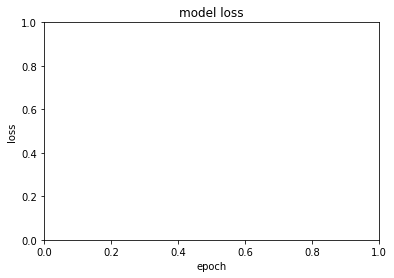

In [20]:
from matplotlib import pyplot as plt
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
#history.history['val_loss']

In [0]:
#Evaluating the model
test_result=[]
with open(os.path.join(dataset_root,'test.json'),'r') as f_eval:
  test_list=json.load(f_eval)

for img in test_list:
  img_path=os.path.join(dataset_root,'images','test',img['filename'])
  img_arr=image.load_img(img_path,target_size=(224,224))
  x=image.img_to_array(img_arr)
  x=preprocess_input(x)
  x=np.expand_dims(x,axis=0)
  output=model.predict(x)
  test_result.append({'filename':img['filename'],'q':output[:4],'r':output[4:]}) 

In [22]:
img_path=os.path.join(dataset_root,'images','test','img000014.jpg')
img_arr=image.load_img(img_path,target_size=(224,224))
x=image.img_to_array(img_arr)
x=preprocess_input(x)
x=np.expand_dims(x,axis=0)
output=model.predict(x)
output

array([[-0.20635211, -0.80298424, -0.18613891,  0.23279394, -0.01594888,
        -0.46830305,  7.3466973 ]], dtype=float32)

In [23]:
img_path=os.path.join(dataset_root,'images','real','img000187real.jpg')
img_arr=image.load_img(img_path,target_size=(224,224))
x=image.img_to_array(img_arr)
x=preprocess_input(x)
x=np.expand_dims(x,axis=0)
output=model.predict(x)
output

array([[-0.51655227, -0.38868752, -0.10576428,  0.48507518, -0.14137167,
        -0.03081699,  2.3164148 ]], dtype=float32)

In [0]:
rgt =3.3147212478
rest =2.3209293745


In [0]:
t=LA.norm([rgt-rest],2)/LA.norm([rgt],2)

In [34]:
t #position_score for image 'img000187real.jpg'

0.2998115977201961